# Final Experiments - Single-label CNNText Non-problem Statement

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5ns, top10ns = mapt(make_non_statement_dataset, [top5s, top10s])

In [3]:
print(len(top10ns[0]))

1159


In [4]:
print(top5ns[0][0])

Input
The first line contains one integer n
(1≤n≤5⋅105
).
The second line contains n
integers a1,a2,…,an
(1≤ai≤5⋅105
).
The third line contains one integer q
(1≤q≤5⋅105
).
Then q
lines follow, i
-th line containing two integers li
and ri
representing i
-th query (1≤li≤ri≤n
).
Output
Answer the queries as follows:
If there is no integer such that it occurs in the subarray from index li
to index ri
exactly once, print 0
. Otherwise print any such integer.
Example
input
Copy
6
1 1 2 3 2 4
2
2 6
1 2
output
Copy
4
0


## CNN Experiments

In [5]:
class CNN_Text(nn.Module):
    def __init__(self, embed_num, class_num, channel_in=1, 
                 kernel_sizes=[3, 4, 5], kernel_num=512, embed_dim=300):
        super().__init__()
        self.kernel_num = kernel_num
        self.embed = nn.Embedding(embed_num, embed_dim)
        
        convs = [nn.Conv1d(1, kernel_num, (ks, embed_dim))
                 for ks in kernel_sizes]
        self.convs = nn.ModuleList(convs)
#         self.bn1 = nn.BatchNorm2d(kernel_num)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x
    
    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        
        out = self.fc1(x)
        return out

### 5-class

In [8]:
trunner = TextRunner([None], top5ns[0], top5ns[1], 'top5ns')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [9]:
runs = 5
out_dim = 5

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Text(in_dim, out_dim),
                               f'{i}_nscnntext5s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

epoch      trn_loss   val_loss   accuracy                  
    0      0.16715    0.153271   0.4       
    1      0.152709   0.143394   0.381818                  
    2      0.139241   0.137654   0.4                       
    3      0.125211   0.134013   0.436364                  
    4      0.111022   0.131914   0.472727                  
    5      0.096967   0.130459   0.509091                   
    6      0.083164   0.128789   0.563636                   
    7      0.069792   0.127722   0.545455                   
    8      0.057229   0.126602   0.545455                   
    9      0.045818   0.125564   0.581818                   

0.5818181818181818


epoch      trn_loss   val_loss   accuracy                  
    0      0.165924   0.154229   0.254545  
    1      0.151666   0.140703   0.4                       
    2      0.13762    0.130759   0.527273                  
    3      0.122506   0.12337    0.545455                  
    4      0.106969   0.120193   0.527273                  
    5      0.091485   0.120037   0.581818                   
    6      0.076473   0.121565   0.563636                   
    7      0.062354   0.1234     0.527273                   
    8      0.049672   0.124995   0.563636                   
    9      0.038803   0.125494   0.563636                   

0.5818181818181818


epoch      trn_loss   val_loss   accuracy                  
    0      0.165323   0.154146   0.327273  
    1      0.152078   0.140462   0.472727                  
    2      0.139234   0.128498   0.563636                  
    3      0.125376   0.122343   0.581818                  
    4      0.110908   0.120553   0.672727                  
    5      0.0963     0.120556   0.654545                   
    6      0.081946   0.120391   0.654545                   
    7      0.068217   0.121737   0.654545                   
    8      0.055401   0.122586   0.618182                   
    9      0.043932   0.123442   0.618182                   

0.6121212121212121


epoch      trn_loss   val_loss   accuracy                  
    0      0.166588   0.156131   0.327273  
    1      0.151727   0.148869   0.345455                  
    2      0.138278   0.143681   0.4                       
    3      0.124184   0.140956   0.436364                  
    4      0.109748   0.14001    0.472727                  
    5      0.095455   0.13828    0.472727                   
    6      0.081469   0.137152   0.509091                   
    7      0.068032   0.13679    0.509091                   
    8      0.055538   0.136824   0.509091                   
    9      0.044326   0.137004   0.509091                   

0.5863636363636363


epoch      trn_loss   val_loss   accuracy                  
    0      0.165525   0.15764    0.163636  
    1      0.151003   0.150455   0.363636                  
    2      0.137407   0.144086   0.363636                  
    3      0.123162   0.13895    0.436364                  
    4      0.108896   0.135629   0.472727                  
    5      0.09488    0.132461   0.454545                   
    6      0.081092   0.131443   0.454545                   
    7      0.067699   0.132173   0.472727                   
    8      0.055104   0.133518   0.490909                   
    9      0.043725   0.135999   0.490909                   

0.5672727272727273


epoch      trn_loss   val_loss   accuracy                  
    0      0.164761   0.159221   0.163636  
    1      0.151793   0.149797   0.381818                  
    2      0.138816   0.138115   0.418182                  
    3      0.124667   0.129389   0.472727                  
    4      0.110181   0.124602   0.472727                  
    5      0.095707   0.121806   0.472727                   
    6      0.08144    0.120431   0.509091                   
    7      0.067773   0.1196     0.545455                   
    8      0.055098   0.119311   0.581818                   
    9      0.043697   0.119185   0.563636                   

0.5696969696969697


epoch      trn_loss   val_loss   accuracy                  
    0      0.165627   0.159669   0.236364  
    1      0.151687   0.155438   0.272727                  
    2      0.13831    0.148841   0.345455                  
    3      0.123731   0.140598   0.418182                  
    4      0.108782   0.135304   0.454545                  
    5      0.094176   0.133159   0.454545                   
    6      0.080056   0.130978   0.454545                   
    7      0.066546   0.130839   0.509091                   
    8      0.053981   0.131674   0.527273                   
    9      0.042756   0.132647   0.527273                   

0.5636363636363636


epoch      trn_loss   val_loss   accuracy                  
    0      0.164314   0.157126   0.290909  
    1      0.149363   0.147202   0.4                       
    2      0.135076   0.14009    0.4                       
    3      0.120377   0.13612    0.454545                  
    4      0.105714   0.134612   0.490909                  
    5      0.091168   0.134247   0.472727                   
    6      0.07688    0.134062   0.436364                   
    7      0.063131   0.134467   0.436364                   
    8      0.050471   0.135878   0.472727                   
    9      0.03934    0.137662   0.490909                   

0.5545454545454546


epoch      trn_loss   val_loss   accuracy                  
    0      0.164433   0.154197   0.345455  
    1      0.150551   0.142462   0.4                       
    2      0.137337   0.132234   0.490909                  
    3      0.12349    0.123807   0.527273                  
    4      0.109303   0.118214   0.563636                  
    5      0.095135   0.113297   0.581818                   
    6      0.08107    0.109423   0.6                        
    7      0.0674     0.10764    0.6                        
    8      0.05466    0.106896   0.618182                   
    9      0.043247   0.106689   0.6                        

0.5616161616161616


epoch      trn_loss   val_loss   accuracy                  
    0      0.166347   0.152167   0.327273  
    1      0.153512   0.140026   0.472727                  
    2      0.140978   0.128719   0.527273                  
    3      0.127152   0.118472   0.563636                  
    4      0.112675   0.114009   0.6                       
    5      0.098137   0.113236   0.581818                   
    6      0.083759   0.112836   0.581818                   
    7      0.0699     0.112408   0.581818                   
    8      0.056905   0.112727   0.6                        
    9      0.045209   0.113413   0.581818                   

0.5654545454545454


epoch      trn_loss   val_loss   accuracy                  
    0      0.166396   0.15962    0.309091  
    1      0.152924   0.140441   0.381818                  
    2      0.140161   0.122546   0.527273                  
    3      0.126481   0.112897   0.618182                  
    4      0.112391   0.108856   0.618182                  
    5      0.098107   0.106936   0.636364                  
    6      0.08386    0.105957   0.672727                   
    7      0.069953   0.106049   0.690909                   
    8      0.056857   0.107177   0.690909                   
    9      0.045069   0.108702   0.672727                   

0.5768595041322314


epoch      trn_loss   val_loss   accuracy                  
    0      0.166228   0.157652   0.345455  
    1      0.150271   0.146925   0.4                       
    2      0.135457   0.138706   0.472727                  
    3      0.120591   0.135537   0.454545                  
    4      0.105999   0.135275   0.490909                  
    5      0.091658   0.134852   0.545455                   
    6      0.07762    0.134298   0.527273                   
    7      0.064172   0.135792   0.527273                   
    8      0.051745   0.137453   0.527273                   
    9      0.040752   0.139004   0.527273                   

0.5742424242424242


epoch      trn_loss   val_loss   accuracy                  
    0      0.165846   0.154501   0.418182  
    1      0.151438   0.142562   0.436364                  
    2      0.138125   0.131704   0.509091                  
    3      0.124332   0.123823   0.618182                  
    4      0.110395   0.118788   0.581818                  
    5      0.096532   0.114271   0.636364                   
    6      0.082711   0.110745   0.636364                   
    7      0.069198   0.108905   0.636364                   
    8      0.056395   0.10861    0.618182                   
    9      0.044883   0.108922   0.618182                   

0.579020979020979


epoch      trn_loss   val_loss   accuracy                  
    0      0.166471   0.151946   0.4       
    1      0.151991   0.142302   0.4                       
    2      0.138546   0.13614    0.436364                  
    3      0.124223   0.133422   0.509091                  
    4      0.109588   0.132264   0.509091                  
    5      0.095011   0.130006   0.490909                   
    6      0.08058    0.12919    0.454545                   
    7      0.066705   0.12996    0.472727                   
    8      0.053812   0.131048   0.472727                   
    9      0.042302   0.132069   0.509091                   

0.574025974025974


epoch      trn_loss   val_loss   accuracy                  
    0      0.16597    0.157577   0.254545  
    1      0.150771   0.150473   0.363636                  
    2      0.136673   0.146545   0.418182                  
    3      0.122133   0.143536   0.418182                  
    4      0.107438   0.142181   0.454545                  
    5      0.092755   0.142811   0.381818                   
    6      0.078369   0.143232   0.4                        
    7      0.064713   0.144442   0.418182                   
    8      0.052117   0.145268   0.454545                   
    9      0.040938   0.145753   0.418182                   

0.566060606060606


epoch      trn_loss   val_loss   accuracy                  
    0      0.165476   0.153567   0.254545  
    1      0.150869   0.148402   0.309091                  
    2      0.136849   0.142397   0.345455                  
    3      0.122356   0.135557   0.472727                  
    4      0.107715   0.129922   0.472727                  
    5      0.093125   0.126375   0.472727                   
    6      0.078781   0.124526   0.472727                   
    7      0.065008   0.124896   0.472727                   
    8      0.052361   0.12654    0.490909                   
    9      0.041222   0.127895   0.490909                   

0.5613636363636364


epoch      trn_loss   val_loss   accuracy                  
    0      0.166172   0.155145   0.236364  
    1      0.151735   0.143768   0.472727                  
    2      0.138098   0.135893   0.436364                  
    3      0.123693   0.131108   0.436364                  
    4      0.109196   0.129446   0.454545                  
    5      0.095026   0.128284   0.490909                   
    6      0.081145   0.127659   0.509091                   
    7      0.067778   0.127863   0.509091                   
    8      0.055282   0.128562   0.490909                   
    9      0.044008   0.129869   0.509091                   

0.558288770053476


epoch      trn_loss   val_loss   accuracy                  
    0      0.165788   0.160954   0.272727  
    1      0.152563   0.151724   0.436364                  
    2      0.140041   0.139881   0.490909                  
    3      0.126245   0.129973   0.472727                  
    4      0.111843   0.124575   0.527273                  
    5      0.097516   0.121908   0.545455                  
    6      0.083453   0.121176   0.563636                   
    7      0.069867   0.121627   0.563636                   
    8      0.057136   0.123265   0.545455                   
    9      0.045667   0.124887   0.527273                   

0.5585858585858586


epoch      trn_loss   val_loss   accuracy                  
    0      0.165123   0.154851   0.381818  
    1      0.151618   0.147373   0.345455                  
    2      0.138673   0.141582   0.436364                  
    3      0.124865   0.137124   0.490909                  
    4      0.110703   0.135683   0.490909                  
    5      0.096572   0.135437   0.490909                   
    6      0.082595   0.135548   0.472727                   
    7      0.069034   0.136417   0.418182                   
    8      0.05633    0.137491   0.418182                   
    9      0.044864   0.13794    0.454545                   

0.5550239234449761


epoch      trn_loss   val_loss   accuracy                  
    0      0.164613   0.153869   0.290909  
    1      0.151629   0.142333   0.436364                  
    2      0.138711   0.133196   0.509091                  
    3      0.124858   0.126244   0.581818                  
    4      0.110714   0.121609   0.6                       
    5      0.096667   0.120116   0.6                        
    6      0.082872   0.119384   0.563636                   
    7      0.069555   0.119634   0.527273                   
    8      0.057028   0.120172   0.527273                   
    9      0.045658   0.120582   0.545455                   

0.5572727272727273


epoch      trn_loss   val_loss   accuracy                  
    0      0.164667   0.153862   0.4       
    1      0.150287   0.143365   0.454545                  
    2      0.136629   0.133608   0.509091                  
    3      0.122407   0.126668   0.509091                  
    4      0.10808    0.122395   0.563636                  
    5      0.093847   0.119756   0.563636                   
    6      0.079846   0.119511   0.545455                   
    7      0.066389   0.119824   0.545455                   
    8      0.053874   0.120154   0.527273                   
    9      0.042669   0.120115   0.509091                   

0.5575757575757576


epoch      trn_loss   val_loss   accuracy                  
    0      0.164469   0.153253   0.345455  
    1      0.150948   0.146778   0.454545                  
    2      0.137176   0.140086   0.454545                  
    3      0.12225    0.136195   0.490909                  
    4      0.107131   0.135652   0.6                       
    5      0.092379   0.134761   0.6                        
    6      0.078137   0.135314   0.581818                   
    7      0.064637   0.136805   0.545455                   
    8      0.052188   0.137494   0.527273                   
    9      0.04114    0.138085   0.527273                   

0.5595041322314049


epoch      trn_loss   val_loss   accuracy                  
    0      0.165835   0.157511   0.236364  
    1      0.151216   0.15201    0.345455                  
    2      0.137102   0.147055   0.363636                  
    3      0.122274   0.142802   0.345455                  
    4      0.107396   0.13951    0.436364                  
    5      0.092736   0.137351   0.436364                   
    6      0.078536   0.136447   0.436364                   
    7      0.065018   0.138232   0.436364                   
    8      0.052548   0.139843   0.418182                   
    9      0.04147    0.141856   0.4                        

0.5541501976284585


epoch      trn_loss   val_loss   accuracy                  
    0      0.165517   0.152702   0.381818  
    1      0.151519   0.142025   0.527273                  
    2      0.138545   0.131506   0.563636                  
    3      0.124735   0.122271   0.6                       
    4      0.110285   0.117278   0.618182                  
    5      0.095726   0.116597   0.563636                   
    6      0.081364   0.117034   0.581818                   
    7      0.067583   0.11804    0.581818                   
    8      0.054735   0.118704   0.618182                   
    9      0.043221   0.119456   0.618182                   

0.5568181818181818


epoch      trn_loss   val_loss   accuracy                  
    0      0.166435   0.152041   0.436364  
    1      0.15262    0.137072   0.490909                  
    2      0.139678   0.12438    0.527273                  
    3      0.126115   0.114819   0.545455                  
    4      0.112155   0.110139   0.6                       
    5      0.098126   0.108072   0.636364                  
    6      0.084215   0.106774   0.636364                   
    7      0.070623   0.106651   0.618182                   
    8      0.057729   0.10781    0.636364                   
    9      0.046036   0.109527   0.636364                   

0.56


epoch      trn_loss   val_loss   accuracy                  
    0      0.16409    0.15102    0.472727  
    1      0.150503   0.137269   0.490909                  
    2      0.137229   0.125386   0.545455                  
    3      0.123311   0.118578   0.563636                  
    4      0.109229   0.11586    0.636364                  
    5      0.095155   0.114326   0.6                        
    6      0.081269   0.113453   0.581818                   
    7      0.067795   0.112524   0.618182                   
    8      0.055211   0.113083   0.636364                   
    9      0.043834   0.113578   0.636364                   

0.5629370629370629


epoch      trn_loss   val_loss   accuracy                  
    0      0.166816   0.156355   0.272727  
    1      0.151617   0.148561   0.345455                  
    2      0.137574   0.142058   0.418182                  
    3      0.123382   0.135947   0.472727                  
    4      0.109183   0.130409   0.509091                  
    5      0.095225   0.125813   0.527273                   
    6      0.08159    0.12308    0.527273                   
    7      0.068325   0.122437   0.563636                   
    8      0.055744   0.122587   0.545455                   
    9      0.044227   0.124135   0.581818                   

0.5636363636363636


epoch      trn_loss   val_loss   accuracy                  
    0      0.16409    0.160936   0.4       
    1      0.150723   0.149776   0.363636                  
    2      0.137366   0.143638   0.4                       
    3      0.123034   0.14186    0.381818                  
    4      0.108592   0.141938   0.454545                  
    5      0.094394   0.141283   0.454545                   
    6      0.08055    0.14095    0.436364                   
    7      0.067272   0.141175   0.454545                   
    8      0.054861   0.141936   0.490909                   
    9      0.043743   0.143155   0.454545                   

0.561038961038961


epoch      trn_loss   val_loss   accuracy                  
    0      0.165412   0.153492   0.345455  
    1      0.151278   0.142263   0.436364                  
    2      0.137697   0.131042   0.545455                  
    3      0.123165   0.122683   0.545455                  
    4      0.108312   0.118681   0.563636                  
    5      0.093685   0.116419   0.581818                   
    6      0.07937    0.115345   0.6                        
    7      0.065696   0.115591   0.6                        
    8      0.053098   0.117199   0.581818                   
    9      0.041949   0.118901   0.563636                   

0.5623824451410658


epoch      trn_loss   val_loss   accuracy                  
    0      0.163981   0.157331   0.236364  
    1      0.150988   0.150116   0.363636                  
    2      0.138006   0.143152   0.381818                  
    3      0.123851   0.138026   0.436364                  
    4      0.10943    0.135579   0.454545                  
    5      0.09524    0.134239   0.490909                   
    6      0.081298   0.132799   0.509091                   
    7      0.067837   0.132233   0.563636                   
    8      0.05523    0.132535   0.581818                   
    9      0.043856   0.132264   0.6                        

0.5636363636363636


epoch      trn_loss   val_loss   accuracy                  
    0      0.164986   0.159327   0.2       
    1      0.149656   0.155442   0.236364                  
    2      0.135579   0.152232   0.327273                  
    3      0.121329   0.148107   0.345455                  
    4      0.106886   0.144754   0.381818                  
    5      0.092534   0.141196   0.436364                   
    6      0.078512   0.1403     0.418182                   
    7      0.065099   0.140958   0.436364                   
    8      0.052659   0.142103   0.472727                   
    9      0.041562   0.143985   0.472727                   

0.5607038123167155


epoch      trn_loss   val_loss   accuracy                  
    0      0.166553   0.153581   0.290909  
    1      0.152333   0.143082   0.418182                  
    2      0.139092   0.135073   0.418182                  
    3      0.125124   0.128281   0.509091                  
    4      0.11064    0.12494    0.545455                  
    5      0.096007   0.122792   0.545455                   
    6      0.081604   0.121403   0.545455                   
    7      0.067801   0.120468   0.563636                   
    8      0.054963   0.120713   0.545455                   
    9      0.043514   0.121245   0.563636                   

0.5607954545454545


epoch      trn_loss   val_loss   accuracy                  
    0      0.167336   0.15975    0.254545  
    1      0.15354    0.145482   0.381818                  
    2      0.140479   0.134215   0.436364                  
    3      0.126222   0.125143   0.472727                  
    4      0.11149    0.120997   0.509091                  
    5      0.096868   0.119195   0.581818                   
    6      0.082616   0.119369   0.563636                   
    7      0.068921   0.119854   0.545455                   
    8      0.056118   0.120719   0.527273                   
    9      0.044567   0.122044   0.527273                   

0.5614325068870524


epoch      trn_loss   val_loss   accuracy                  
    0      0.166118   0.154885   0.290909  
    1      0.152634   0.147613   0.418182                  
    2      0.139674   0.140655   0.4                       
    3      0.125607   0.134761   0.472727                  
    4      0.111209   0.130608   0.454545                  
    5      0.096939   0.128705   0.490909                   
    6      0.082912   0.126503   0.490909                   
    7      0.069328   0.12533    0.563636                   
    8      0.056572   0.125633   0.563636                   
    9      0.045079   0.126325   0.545455                  

0.5614973262032086


epoch      trn_loss   val_loss   accuracy                  
    0      0.165125   0.150529   0.436364  
    1      0.150368   0.146664   0.418182                  
    2      0.136299   0.145482   0.472727                  
    3      0.121681   0.143958   0.454545                  
    4      0.107203   0.14197    0.454545                  
    5      0.093112   0.140122   0.418182                   
    6      0.079414   0.138179   0.4                        
    7      0.066219   0.138152   0.4                        
    8      0.053936   0.137439   0.436364                   
    9      0.042894   0.13655    0.454545                   

0.558961038961039


epoch      trn_loss   val_loss   accuracy                  
    0      0.16538    0.15255    0.272727  
    1      0.151537   0.147723   0.418182                  
    2      0.13845    0.139706   0.454545                  
    3      0.1244     0.131565   0.472727                  
    4      0.109769   0.125449   0.527273                  
    5      0.094975   0.121476   0.581818                   
    6      0.080312   0.118373   0.618182                   
    7      0.06618    0.119297   0.6                        
    8      0.05319    0.120934   0.6                        
    9      0.041774   0.12352    0.581818                   

0.5606060606060606


epoch      trn_loss   val_loss   accuracy                  
    0      0.165765   0.15963    0.127273  
    1      0.15109    0.146367   0.472727                  
    2      0.137128   0.133625   0.509091                  
    3      0.122388   0.125064   0.545455                  
    4      0.107461   0.120884   0.527273                  
    5      0.092754   0.118814   0.563636                   
    6      0.078474   0.117314   0.545455                   
    7      0.064827   0.117365   0.527273                   
    8      0.052214   0.118305   0.527273                   
    9      0.041025   0.119493   0.527273                   

0.5606879606879607


epoch      trn_loss   val_loss   accuracy                  
    0      0.164607   0.158413   0.145455  
    1      0.150566   0.150479   0.327273                  
    2      0.136961   0.144505   0.381818                  
    3      0.122631   0.140514   0.436364                  
    4      0.108063   0.137857   0.490909                  
    5      0.09359    0.136447   0.490909                   
    6      0.079529   0.137508   0.490909                   
    7      0.066175   0.138951   0.509091                   
    8      0.053795   0.140085   0.527273                   
    9      0.042691   0.140984   0.527273                   

0.5598086124401914


epoch      trn_loss   val_loss   accuracy                  
    0      0.164879   0.153274   0.290909  
    1      0.149019   0.137798   0.527273                  
    2      0.134635   0.127056   0.581818                  
    3      0.120413   0.120741   0.563636                  
    4      0.106231   0.116922   0.581818                  
    5      0.092099   0.11336    0.6                        
    6      0.078132   0.110634   0.6                        
    7      0.064693   0.10942    0.618182                   
    8      0.052228   0.109121   0.618182                   
    9      0.041128   0.109278   0.636364                   

0.5617715617715617


epoch      trn_loss   val_loss   accuracy                  
    0      0.165239   0.157465   0.309091  
    1      0.151802   0.145241   0.454545                  
    2      0.138475   0.134183   0.418182                  
    3      0.12412    0.126124   0.509091                  
    4      0.109575   0.121492   0.545455                  
    5      0.095131   0.118708   0.509091                   
    6      0.080989   0.116875   0.509091                   
    7      0.067415   0.115978   0.527273                   
    8      0.054734   0.115327   0.527273                   
    9      0.043343   0.114977   0.509091                   

0.5613636363636364


epoch      trn_loss   val_loss   accuracy                  
    0      0.166445   0.156487   0.345455  
    1      0.151882   0.153235   0.381818                  
    2      0.138584   0.148906   0.327273                  
    3      0.124601   0.145336   0.381818                  
    4      0.110269   0.144824   0.436364                  
    5      0.096001   0.145198   0.418182                   
    6      0.081946   0.144711   0.418182                   
    7      0.068374   0.145318   0.454545                   
    8      0.055663   0.14691    0.454545                   
    9      0.044234   0.147356   0.454545                   

0.5587583148558758


epoch      trn_loss   val_loss   accuracy                  
    0      0.165252   0.151585   0.381818  
    1      0.15131    0.13825    0.454545                  
    2      0.138107   0.126338   0.527273                  
    3      0.124087   0.116888   0.6                       
    4      0.109711   0.110495   0.618182                  
    5      0.095339   0.106736   0.6                        
    6      0.081076   0.10475    0.6                        
    7      0.067179   0.10457    0.581818                   
    8      0.054215   0.105055   0.581818                   
    9      0.042634   0.106188   0.6                        

0.5601731601731602


epoch      trn_loss   val_loss   accuracy                  
    0      0.165414   0.158046   0.2       
    1      0.151586   0.145604   0.327273                  
    2      0.13824    0.135105   0.472727                  
    3      0.124047   0.128118   0.527273                  
    4      0.10962    0.124194   0.527273                  
    5      0.095349   0.122623   0.563636                  
    6      0.081324   0.121905   0.581818                   
    7      0.06772    0.122339   0.6                        
    8      0.054928   0.123495   0.581818                   
    9      0.043385   0.125345   0.563636                   

0.5610993657505285


epoch      trn_loss   val_loss   accuracy                  
    0      0.166265   0.155393   0.381818  
    1      0.151634   0.148249   0.363636                  
    2      0.137999   0.141378   0.381818                  
    3      0.123815   0.134069   0.4                       
    4      0.109473   0.129099   0.472727                  
    5      0.095277   0.125866   0.527273                   
    6      0.081306   0.124532   0.527273                   
    7      0.067883   0.12407    0.527273                   
    8      0.055328   0.124438   0.563636                   
    9      0.044036   0.125335   0.545455                   

0.5611570247933885


epoch      trn_loss   val_loss   accuracy                  
    0      0.165701   0.152221   0.454545  
    1      0.151502   0.134943   0.509091                  
    2      0.138146   0.120816   0.581818                  
    3      0.124171   0.110983   0.6                       
    4      0.109898   0.105241   0.672727                  
    5      0.095682   0.101863   0.690909                   
    6      0.081659   0.099501   0.690909                   
    7      0.06812    0.09793    0.727273                   
    8      0.055429   0.096201   0.727273                   
    9      0.044018   0.095468   0.781818                   

0.566060606060606


epoch      trn_loss   val_loss   accuracy                  
    0      0.164176   0.159354   0.2       
    1      0.150069   0.162837   0.218182                  
    2      0.136673   0.164036   0.272727                  
    3      0.122584   0.160953   0.327273                  
    4      0.108273   0.157575   0.363636                  
    5      0.094057   0.154622   0.381818                   
    6      0.080101   0.151419   0.4                        
    7      0.066669   0.151231   0.363636                   
    8      0.054151   0.151706   0.363636                   
    9      0.042934   0.151814   0.363636                   

0.5624505928853755


epoch      trn_loss   val_loss   accuracy                  
    0      0.165349   0.157979   0.309091  
    1      0.151112   0.148702   0.381818                  
    2      0.137533   0.14049    0.418182                  
    3      0.123051   0.13576    0.472727                  
    4      0.108155   0.134685   0.527273                  
    5      0.093368   0.134235   0.509091                   
    6      0.078974   0.133504   0.509091                   
    7      0.065234   0.133824   0.509091                   
    8      0.05251    0.134307   0.509091                   
    9      0.041201   0.135081   0.509091                   

0.5617021276595745


epoch      trn_loss   val_loss   accuracy                  
    0      0.165981   0.153575   0.327273  
    1      0.151477   0.14675    0.363636                  
    2      0.137931   0.141736   0.418182                  
    3      0.123809   0.139022   0.472727                  
    4      0.109398   0.138826   0.472727                  
    5      0.095076   0.138429   0.490909                   
    6      0.081025   0.137952   0.472727                   
    7      0.067496   0.138227   0.472727                   
    8      0.054845   0.139876   0.490909                   
    9      0.043461   0.141612   0.490909                   

0.5602272727272727


epoch      trn_loss   val_loss   accuracy                  
    0      0.165347   0.154674   0.4       
    1      0.151263   0.139006   0.490909                  
    2      0.13772    0.124734   0.6                       
    3      0.123356   0.117227   0.690909                  
    4      0.108626   0.115322   0.690909                  
    5      0.09386    0.115333   0.654545                   
    6      0.079306   0.11502    0.654545                   
    7      0.065404   0.114693   0.654545                   
    8      0.052623   0.115468   0.618182                   
    9      0.041331   0.116383   0.6                        

0.5628942486085343


epoch      trn_loss   val_loss   accuracy                  
    0      0.164977   0.151176   0.345455  
    1      0.150836   0.133069   0.581818                  
    2      0.137276   0.119234   0.618182                  
    3      0.122986   0.110075   0.636364                  
    4      0.108496   0.105544   0.636364                  
    5      0.094062   0.104394   0.636364                   
    6      0.079783   0.103851   0.618182                   
    7      0.065927   0.104824   0.636364                   
    8      0.053076   0.106557   0.618182                   
    9      0.041698   0.108357   0.581818                   

0.5643636363636364


In [2]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-io_5s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-io_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures    0.58549   0.82182   0.68381       550
             dp    0.58672   0.28909   0.38733       550
         greedy    0.54631   0.52545   0.53568       550
 implementation    0.55512   0.51273   0.53308       550
           math    0.55224   0.67273   0.60656       550

    avg / total    0.56518   0.56436   0.54929      2750

0.5643636363636364
0.5492929551077546
Normalized confusion matrix
[[0.82182 0.03818 0.06909 0.02    0.05091]
 [0.16727 0.28909 0.17091 0.17455 0.19818]
 [0.13273 0.05273 0.52545 0.13818 0.15091]
 [0.16    0.04909 0.13273 0.51273 0.14545]
 [0.12182 0.06364 0.06364 0.07818 0.67273]]
0.8218181818181818


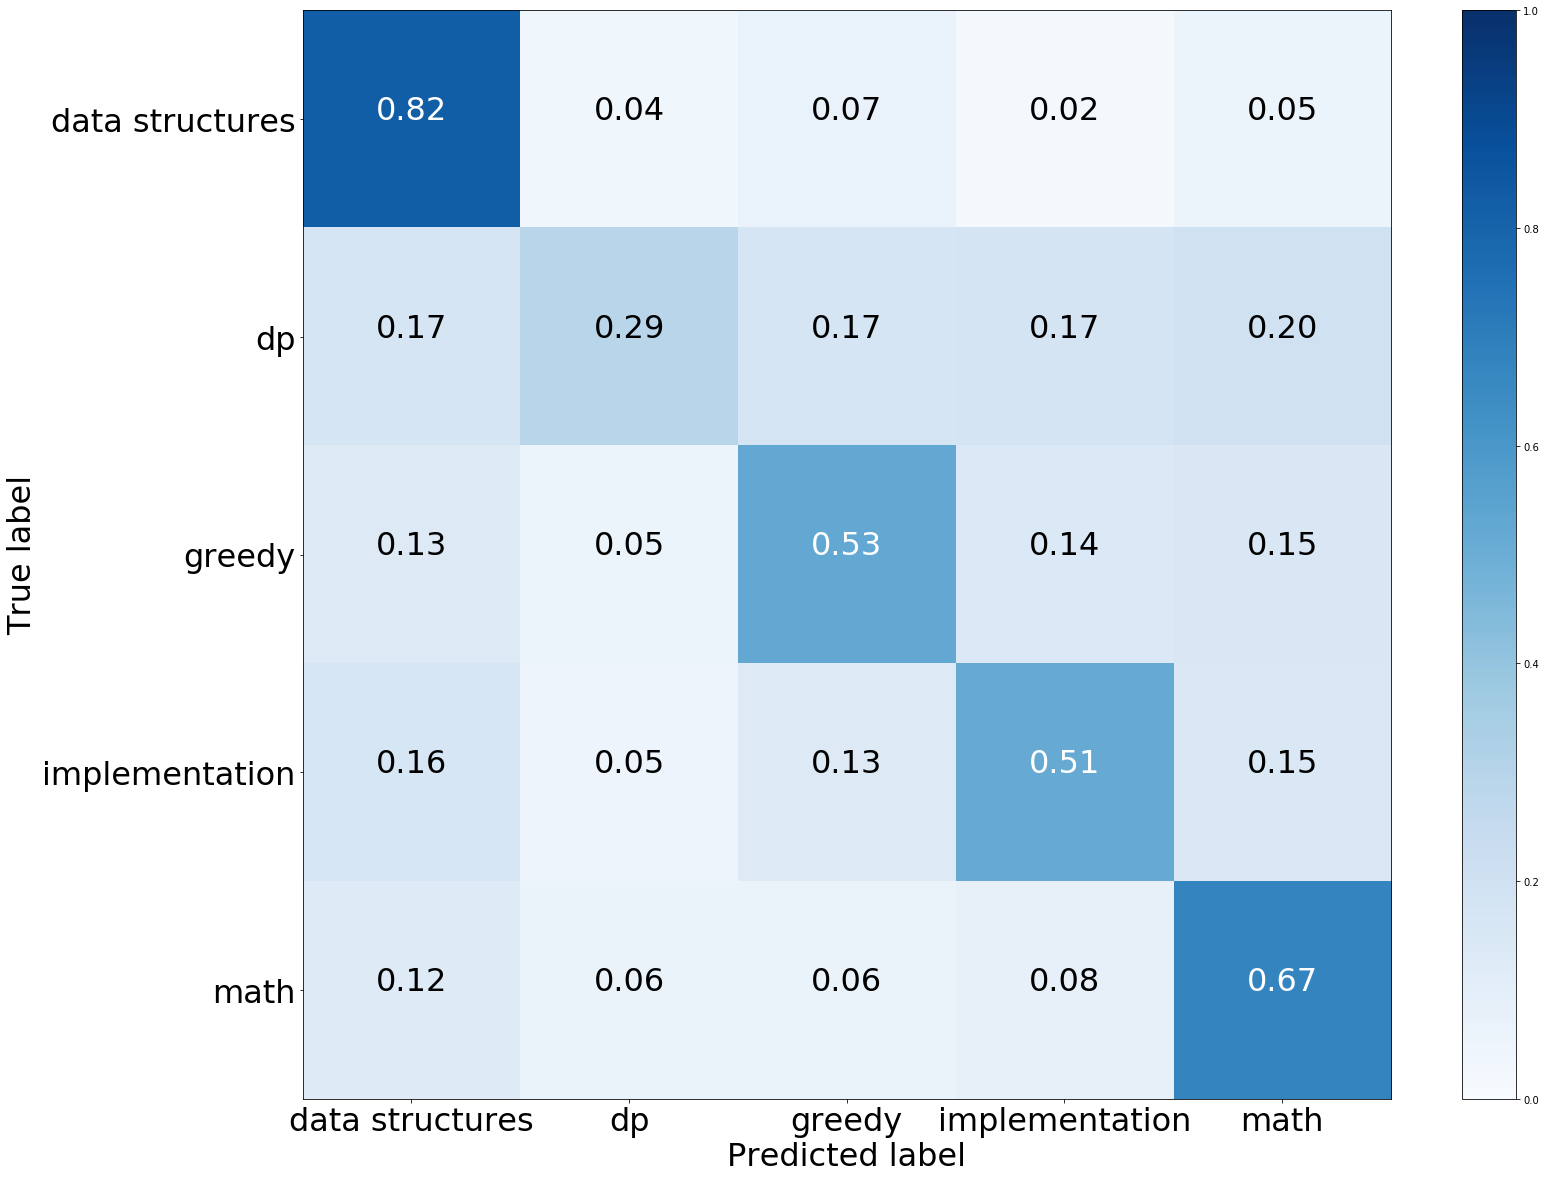

In [3]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt, labels=labels, digits=5))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)